# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/NotAveragePooled/split_features_6s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [5]:
# train_data]

In [6]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [7]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [8]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [9]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [10]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [11]:
# display(train_y.shape)
# display(train_y[:15])

In [12]:
# for key in train_features.keys():
#   display(key)
#   display(train_features[key].shape)
#   display(train_features[key][0])

In [13]:
# display(val_y.shape)
# display(val_y[:15])

In [14]:
# for key in val_features.keys():
#   display(key)
#   display(val_features[key].shape)
#   display(val_features[key][0])

## **LSTM Model**

In [64]:
def build_model(audio_features,
                learning_rate=0.00001,
                lstm_units=256,
                hidden_layers=[128, 64, 32],
                dropout_rate=0.1):

    tf.keras.backend.clear_session()

    # Input layer
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2]), name='Audio_Features')

    x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Second LSTM layer
    x = tf.keras.layers.LSTM(lstm_units//2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Fully connected layers
    for units in hidden_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=20, activation='softmax')(x)

    # Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    print(model.summary())

    return model


In [65]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [66]:
train_results = {}
val_results = {}

### **With all the features**

In [67]:
# n_time = train_features['melspectrogram'].shape[2]

# mfcc_tiled = np.tile(train_features['mfcc'], (1, 3, 1))  # (3318, 60, 44), tiling 3 times to match 60 features
# chroma_tiled = np.tile(train_features['chroma'], (1, 5, 1))  # (3318, 60, 44), tiling 5 times to match 60 features
# rms_tiled = np.tile(train_features['rms'], (1, 60, 1))  # (3318, 60, 44), tiling 60 times to match 60 features

training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma'], train_features['rms']), axis=1)

print(training_features.shape)

(3954, 93, 259)


In [68]:
# mfcc_val_tiled = np.tile(val_features['mfcc'], (1, 3, 1))  # Tile to (n_samples_val, 60, 44)
# chroma_val_tiled = np.tile(val_features['chroma'], (1, 5, 1))  # Tile to (n_samples_val, 60, 44)
# rms_val_tiled = np.tile(val_features['rms'], (1, 60, 1))  # Tile to (n_samples_val, 60, 44)

# melspectrogram_val = val_features['melspectrogram']

validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma'], val_features['rms']), axis=1)

print(validation_features.shape)

(985, 93, 259)


Fit the model with training data

In [69]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
# print('best_epoch: ', best_epoch)
visualize(history)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 93, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 93, 256)             │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 93, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 93, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 755,444 (2.88 MB)

 Trainable params: 754,228 (2.88 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0547 - loss: 6.0267 - val_accuracy: 0.0112 - val_loss: 5.7138
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0674 - loss: 5.8481 - val_accuracy: 0.0173 - val_loss: 5.8233
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0885 - loss: 5.7019 - val_accuracy: 0.0386 - val_loss: 5.7190
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1041 - loss: 5.5906 - val_accuracy: 0.1015 - val_loss: 5.4539
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1306 - loss: 5.4746 - val_accuracy: 0.1421 - val_loss: 5.3800
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1309 - loss: 5.4562 - val_accuracy: 0.1594 - val_loss: 5.3001
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1519 - loss: 5.3751 - val_accuracy: 0.1685 - val_loss: 5.2348
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1515 - loss: 5.35

KeyError: 'val_weighted_accuracy'

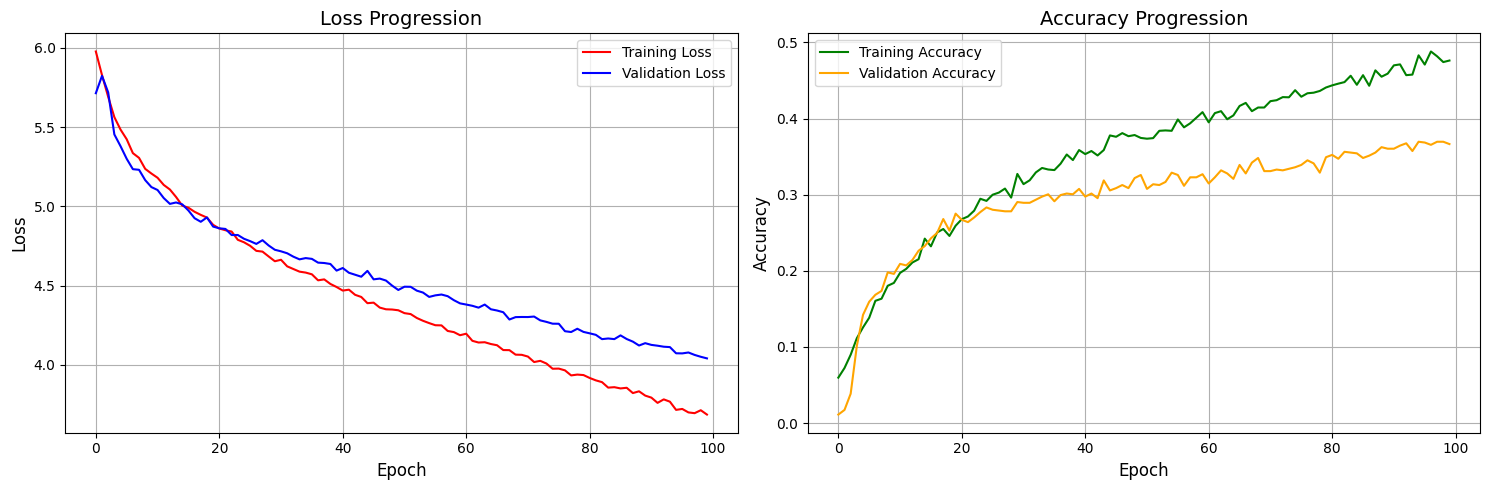

In [70]:
visualize(history)

In [71]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5812 - loss: 3.3834
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3516 - loss: 4.0529


## **With Mel-Spectrogram, MFCCs, Chroma**

In [72]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma']), axis=1)

print(training_features.shape)

(3954, 92, 259)


In [73]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma']), axis=1)

print(validation_features.shape)

(985, 92, 259)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 92, 259)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 92, 256)             │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 92, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 92, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 755,444 (2.88 MB)

 Trainable params: 754,228 (2.88 MB)

 Non-trainable params: 1,216 (4.75 KB)

None
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0577 - loss: 6.0930 - val_accuracy: 0.0944 - val_loss: 5.6246
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0756 - loss: 5.8899 - val_accuracy: 0.0975 - val_loss: 5.6610
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1075 - loss: 5.7173 - val_accuracy: 0.0853 - val_loss: 5.5429
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1105 - loss: 5.6826 - val_accuracy: 0.1289 - val_loss: 5.4383
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1196 - loss: 5.6008 - val_accuracy: 0.1523 - val_loss: 5.3923
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1339 - loss: 5.4859 - val_accuracy: 0.1533 - val_loss: 5.3497
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1422 - loss: 5.4940 - val_accuracy: 0.1655 - val_loss: 5.3252
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1450 - loss: 5.45

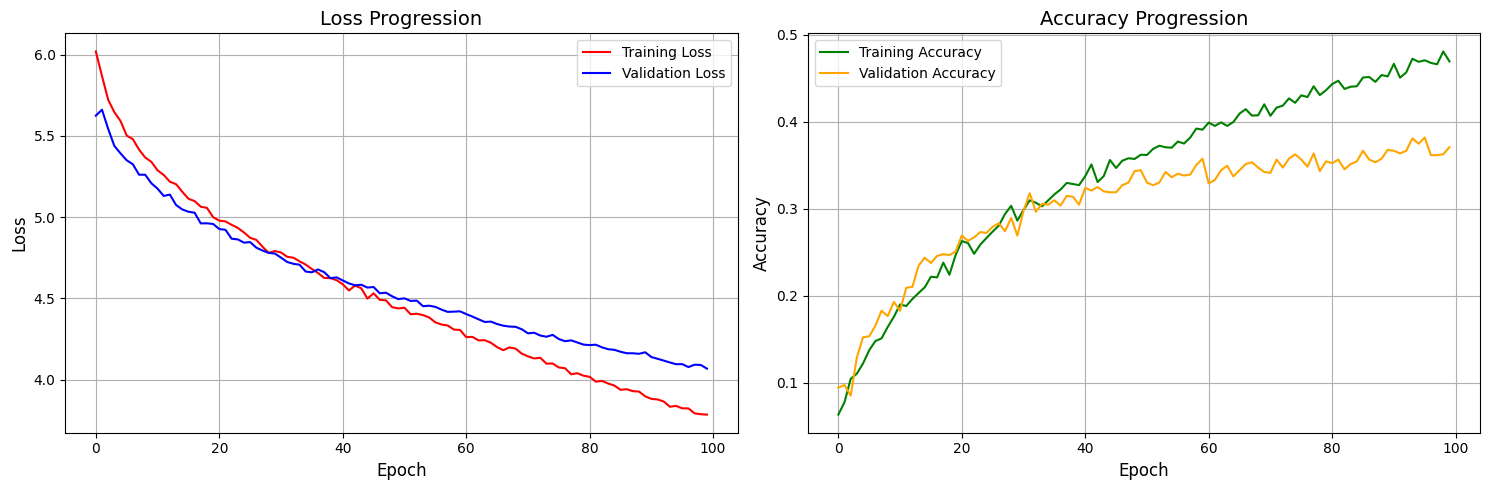

In [74]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
# print('best_epoch: ', best_epoch)
visualize(history)

In [75]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5857 - loss: 3.4383
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3504 - loss: 4.1130


# Review results from all models

In [76]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.586,0.366
1,melspectrogram_chroma_mfcc,0.588,0.371
